<a href="https://colab.research.google.com/github/igomezv/VAE_NBody/blob/main/Autoencoder_latent_dim_8_isidro_hackaton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

import os
import numpy as np

from PIL import Image
import cv2
import skimage.measure
import skimage.io

print(tf.__version__)

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

tf.config.list_physical_devices('GPU')

from tensorflow.python.client import device_lib

device_lib.list_local_devices()

tf.test.is_built_with_cuda()

#tf.debugging.set_log_device_placement(False)

2.13.0
Num GPUs Available:  1


True

In [2]:
! git clone https://github.com/ChJazhiel/VAE_NBody.git

fatal: destination path 'VAE_NBody' already exists and is not an empty directory.


In [3]:
# root_dir = "/home/isidro/Documents/github/"

image_dir = "/content/VAE_NBody/Projections_axis_off"
images = [os.path.join(image_dir, image) for image in os.listdir(image_dir)]
images[:2]


image_halos_dir = "/content/VAE_NBody/HALOS_Axis_off/Axis_off"
images_halos = [os.path.join(image_halos_dir, image) for image in os.listdir(image_halos_dir)]
images_halos[:2]

['/content/VAE_NBody/HALOS_Axis_off/Axis_off/D27_z_axis_off_Projection_z_density_density.png',
 '/content/VAE_NBody/HALOS_Axis_off/Axis_off/D35_y_axis_off_Projection_y_density_density.png']

In [4]:
 len(images_halos), type(images_halos)

(78, list)

In [5]:
shuffle_idx = np.random.permutation(len(images))
shuffle_idx

array([33, 48,  5, 42, 68, 15, 75, 71, 62, 32, 47, 72, 53, 26, 20, 51, 45,
       49, 23,  7, 57, 41,  6, 27, 22, 70, 35, 36, 40, 76, 55,  1, 63, 24,
       29, 60, 58, 39, 28, 44, 21, 61, 77,  8, 38, 18, 73, 25, 66, 30,  2,
       12, 56, 37, 34, 67,  3, 64, 52, 59, 74, 46, 65, 10, 17, 31,  9, 69,
       54, 13, 50, 11,  0, 19, 16, 14, 43,  4])

In [6]:
images = [images[idx] for idx in shuffle_idx]
images_halos = [images_halos[idx] for idx in shuffle_idx]

In [7]:
# preprocess
image_size = 256

## tf.io is an api for image processing



#TensorFlow I/O is a collection of file systems and file formats that are not available in TensorFlow's built-in
#support.

#It provides useful extra Dataset, streaming, and file system extensions, and is maintained by TensorFlow SIG-IO.

#### add a tf.crop in order to resize and add the 3 color channels


def preprocess(image):
    image = skimage.io.imread(image)
    image = cv2.resize(image, (image_size, image_size), interpolation=cv2.INTER_CUBIC)
    image = np.reshape(image, (image_size, image_size, 4))
    # image = tf.io.decode_jpeg(image)
    # #image = tf.cast(image, tf.float32)
    # image = tf.image.resize(image, (image_size, image_size))
    image = image / 255.0
    # # image = tf.image.random_crop(image,  size=[256,256,4])
    # image = tf.reshape(image, shape = (image_size, image_size, 4,))
    image = image[:,:,:3]
    return image

In [8]:
training_dataset = [preprocess(image) for image in images]
training_dataset_halos = [preprocess(image) for image in images_halos]

In [9]:
np.shape(training_dataset), np.shape(training_dataset_halos)

((78, 256, 256, 3), (78, 256, 256, 3))

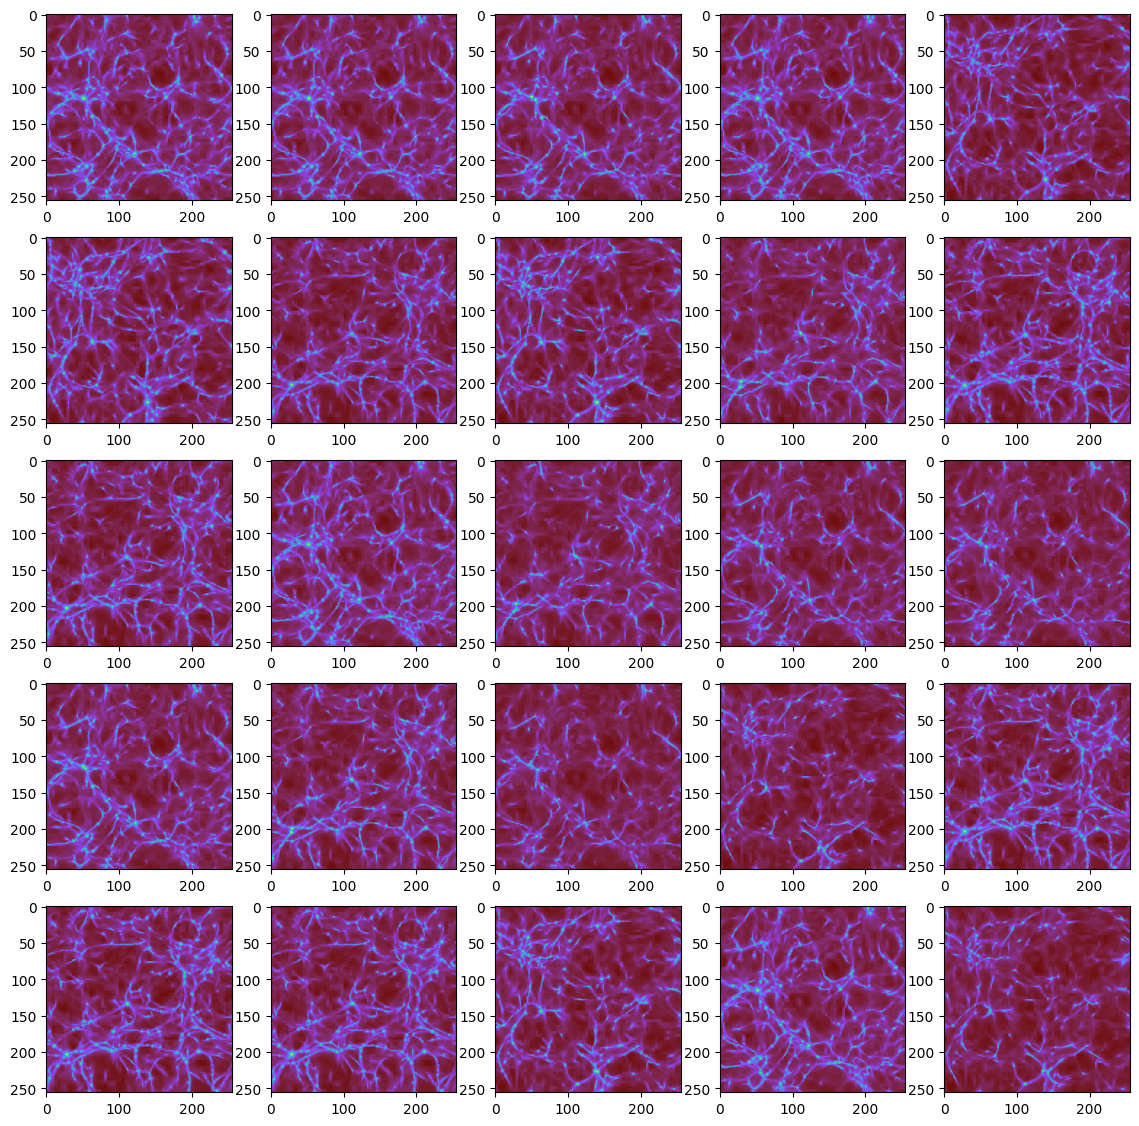

In [10]:
# visualize some of them
fig, axes = plt.subplots(5,5, figsize = (14,14))
# training_dataset[:25]

idx = 0
# for img in sample:
  # img = img[0, :, :, :]
for row in range(5):
    for column in range(5):
        axes[row, column].imshow(training_dataset[idx][:, :, :])
        idx += 1

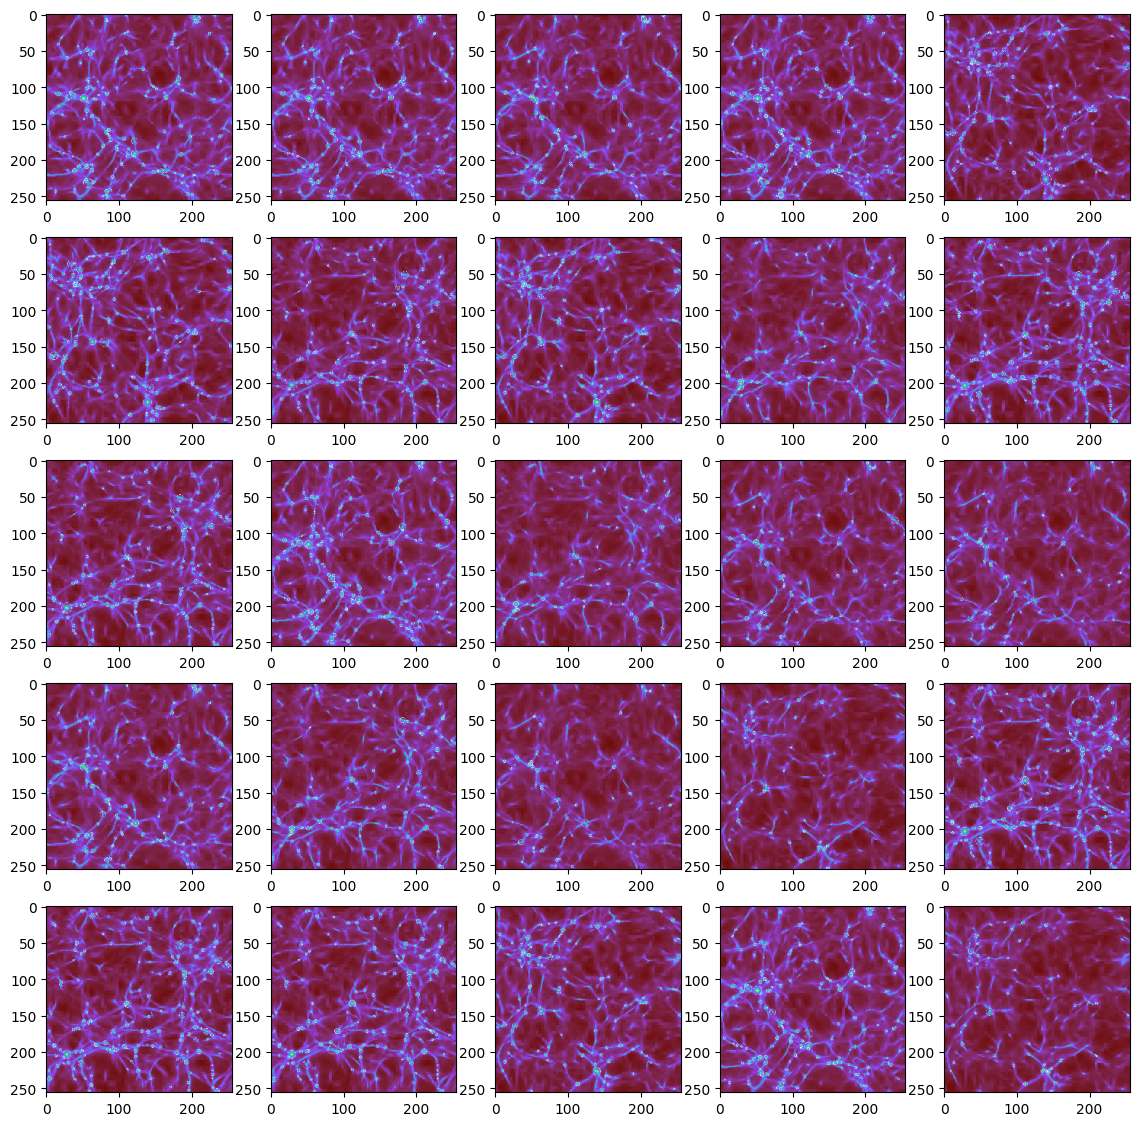

In [11]:
# visualize some of them
fig, axes = plt.subplots(5,5, figsize = (14,14))
# training_dataset[:25]

idx = 0
# for img in sample:
  # img = img[0, :, :, :]
for row in range(5):
    for column in range(5):
        axes[row, column].imshow(training_dataset_halos[idx][:, :, :])
        idx += 1

In [12]:
## Necessary imports

from keras.models import Sequential, Model
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Dense, Conv2D, Conv2DTranspose, Input, Flatten, BatchNormalization, Lambda, Reshape, Activation
from keras.optimizers import Adam


In [29]:
# np.shape(training_dataset)
training_dataset = np.reshape(training_dataset, (len(training_dataset),1,256,256,3))
training_dataset_halos = np.reshape(training_dataset_halos, (len(training_dataset),1,256,256,3))

In [30]:
# Define the encoder
encoder_input = keras.Input(shape=(1, 256, 256, 3))
x = layers.Conv2D(32, (3,3), activation="relu", strides=2, padding="same")(encoder_input)
x = layers.Conv2D(64, (3,3), activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(128, (3,3), activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(256, (3,3), activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
z_mean = layers.Dense(8)(x)
z_log_var = layers.Dense(8)(x)



In [31]:
# Reparameterization trick to sample from the latent space
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.keras.backend.random_normal(shape=(tf.shape(z_mean)[0], 8), mean=0., stddev=1.0)
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])

encoder = keras.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")


In [32]:
# Define the decoder
latent_input = keras.Input(shape=(8,))
x = layers.Dense(32 * 32 * 256, activation="relu")(latent_input)
x = layers.Reshape((32, 32, 256))(x)
x = layers.Conv2DTranspose(128, (3,3), activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(64, (3,3), activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, (3,3), activation="relu", strides=2, padding="same")(x)
decoder_output = layers.Conv2DTranspose(3, (3,3), activation="sigmoid", padding="same")(x)

decoder = keras.Model(latent_input, decoder_output, name="decoder")

In [33]:
# Define the VAE as a whole
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.mean_squared_error(data, reconstruction)
            )
            kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

# Create the VAE
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(0.001, 0.3))


In [34]:
vae.encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 1, 256, 256, 3)]     0         []                            
                                                                                                  
 conv2d_4 (Conv2D)           (None, 1, 128, 128, 32)      896       ['input_3[0][0]']             
                                                                                                  
 conv2d_5 (Conv2D)           (None, 1, 64, 64, 64)        18496     ['conv2d_4[0][0]']            
                                                                                                  
 conv2d_6 (Conv2D)           (None, 1, 32, 32, 128)       73856     ['conv2d_5[0][0]']            
                                                                                            

In [35]:
vae.decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 8)]               0         
                                                                 
 dense_5 (Dense)             (None, 262144)            2359296   
                                                                 
 reshape_1 (Reshape)         (None, 32, 32, 256)       0         
                                                                 
 conv2d_transpose_4 (Conv2D  (None, 64, 64, 128)       295040    
 Transpose)                                                      
                                                                 
 conv2d_transpose_5 (Conv2D  (None, 128, 128, 64)      73792     
 Transpose)                                                      
                                                                 
 conv2d_transpose_6 (Conv2D  (None, 256, 256, 32)      1846

In [36]:
#  vae.fit(x=training_dataset, y=training_dataset_halos, epochs=10, batch_size=8)
vae.fit(x=training_dataset, y=training_dataset_halos, epochs=10, batch_size=8)

Epoch 1/10
10/10 [==============================] - 6s 59ms/step - loss: 0.0679 - reconstruction_loss: 0.0524 - kl_loss: 0.0155
Epoch 2/10
10/10 [==============================] - 0s 45ms/step - loss: 0.0246 - reconstruction_loss: 0.0246 - kl_loss: 2.2902e-06
Epoch 3/10
10/10 [==============================] - 0s 46ms/step - loss: 0.0212 - reconstruction_loss: 0.0212 - kl_loss: 5.1178e-07
Epoch 4/10
10/10 [==============================] - 0s 47ms/step - loss: 0.0212 - reconstruction_loss: 0.0212 - kl_loss: 3.8301e-07
Epoch 5/10
10/10 [==============================] - 0s 49ms/step - loss: 0.0211 - reconstruction_loss: 0.0211 - kl_loss: 4.7304e-07
Epoch 6/10
10/10 [==============================] - 0s 48ms/step - loss: 0.0205 - reconstruction_loss: 0.0205 - kl_loss: 2.9719e-07
Epoch 7/10
10/10 [==============================] - 0s 48ms/step - loss: 0.0196 - reconstruction_loss: 0.0196 - kl_loss: 4.4008e-07
Epoch 8/10
10/10 [==============================] - 0s 48ms/step - loss: 0.0194 

In [37]:
latent_dim = 8

random_vector_1 = tf.random.normal(shape = (8, latent_dim,))
random_vector_2 = tf.random.normal(shape = (8, latent_dim,))


generated_images_1 = vae.decoder.predict(random_vector_1)
generated_images_2 = vae.decoder.predict(random_vector_2)
len

1/1 [==============================] - 0s 19ms/step


<function len(obj, /)>

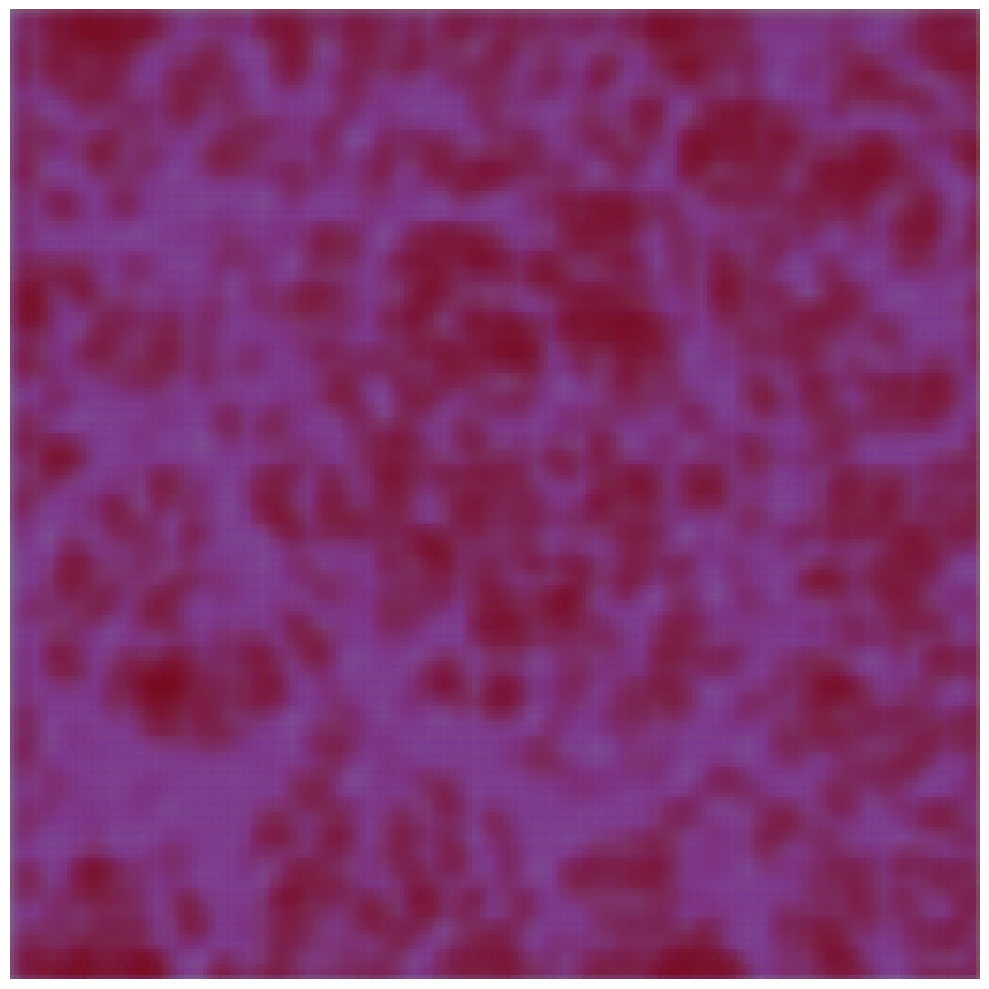

In [38]:
# Plot the generated images
n = len(generated_images_1)
rows = 8
cols = n // rows

plt.figure(figsize=(10, 10))
for i in range(n):
    #plt.subplot(rows, cols, i + 1)
    plt.imshow(generated_images_1[i])
    #plt.imshow(generated_images_2[i])
    plt.axis('off')

plt.tight_layout()
plt.show()

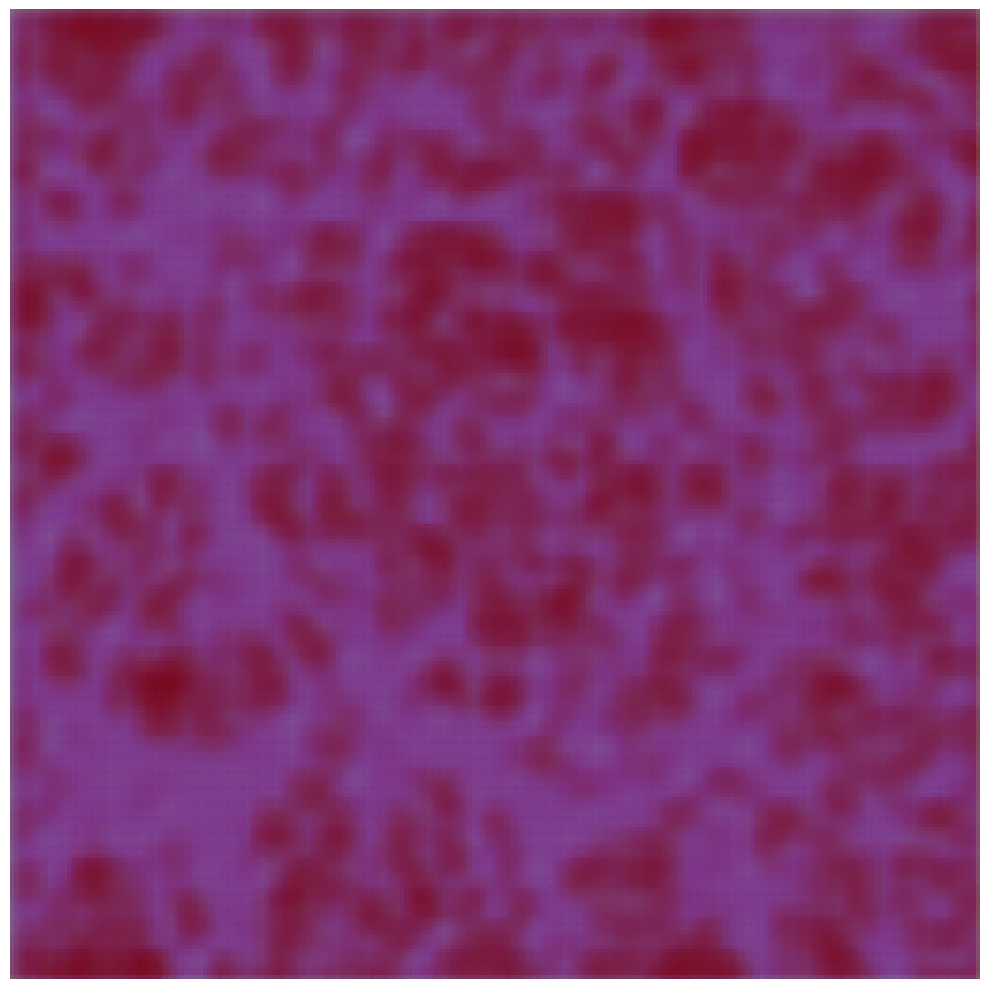

In [39]:
# Plot the generated images
n = len(generated_images_1)
rows = 8
cols = n // rows

plt.figure(figsize=(10, 10))
for i in range(n):
    #plt.subplot(rows, cols, i + 1)
    #plt.imshow(generated_images_1[i])
    plt.imshow(generated_images_2[i])
    plt.axis('off')

plt.tight_layout()
plt.show()

In [40]:
###Graficar media y varianza

## cambiar tamaño del filtro a 3x3 o 5x5

In [41]:
tf.shape(z_mean)

<KerasTensor: shape=(2,) dtype=int32 inferred_value=[None, 8] (created by layer 'tf.compat.v1.shape_1')>

In [42]:
print(z_mean)

KerasTensor(type_spec=TensorSpec(shape=(None, 8), dtype=tf.float32, name=None), name='dense_3/BiasAdd:0', description="created by layer 'dense_3'")


In [43]:
print(z)

KerasTensor(type_spec=TensorSpec(shape=(None, 8), dtype=tf.float32, name=None), name='lambda_1/add:0', description="created by layer 'lambda_1'")


3/3 [==============================] - 1s 83ms/step


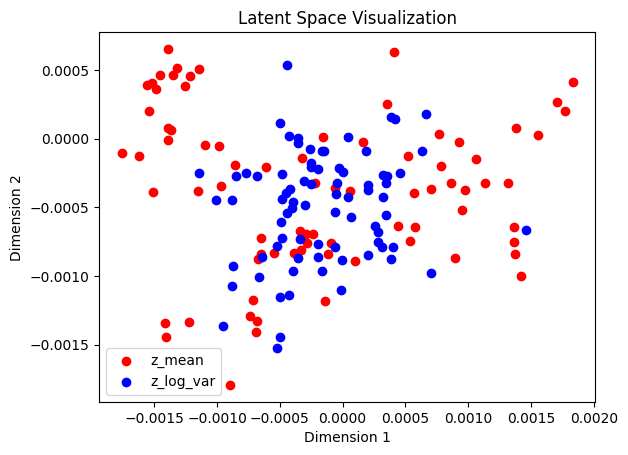

In [44]:
latent_dim = 8

random_vector_1 = tf.random.normal(shape = (8, latent_dim,))
random_vector_2 = tf.random.normal(shape = (8, latent_dim,))


generated_images_1 = vae.decoder.predict(random_vector_1)
generated_images_2 = vae.decoder.predict(random_vector_2)

encoded = vae.encoder.predict(training_dataset)

z_mean_values = encoded[0]  # Extract z_mean values
z_log_var_values = encoded[1]  # Extract z_log_var values

# Now you can plot z_mean and z_log_var in a 2D plot
plt.scatter(z_mean_values[:, 0], z_mean_values[:, 1], c='r', label='z_mean')
plt.scatter(z_log_var_values[:, 0], z_log_var_values[:, 1], c='b', label='z_log_var')
plt.legend()
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Latent Space Visualization')
plt.show()